In [9]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub        
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
# Load the pre-trained EfficientDet model from TensorFlow Hub
model_url = "https://tfhub.dev/tensorflow/efficientdet/d7/1"
model = hub.load(model_url)

# Load an image for testing
image_path = "img2.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to tf.uint8
input_image = tf.convert_to_tensor(image, dtype=tf.uint8)

In [ ]:
# Add batch dimension
input_image = tf.expand_dims(input_image, axis=0)

# Perform inference
predictions = model(input_image)

# Post-process the predictions
result = {key: value[0].numpy() for key, value in predictions.items()}  # Ensure we extract a single element from each array

# Extract the number of detections from the 'num_detections' array
num_detections = int(result["num_detections"])

# Initialize crowd density
crowd_density = 0

# Create an empty heatmap
heatmap = np.zeros_like(image[:, :, 0], dtype=np.float32)

In [ ]:

# Draw bounding boxes on the image for detected persons and calculate crowd density
for i in range(num_detections):
    box = result["detection_boxes"][i]
    class_id = int(result["detection_classes"][i])
    score = result["detection_scores"][i]  # Access the score directly

    # Check if the detected object is a person (class ID 1)
    if class_id == 1 and score > 0.5:  # Adjust the threshold as needed
        ymin, xmin, ymax, xmax = box
        xmin = int(xmin * image.shape[1])
        xmax = int(xmax * image.shape[1])
        ymin = int(ymin * image.shape[0])
        ymax = int(ymax * image.shape[0])

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        # Increment crowd density
        crowd_density += 1

        # Add density to the heatmap in the bounding box region
        heatmap[ymin:ymax, xmin:xmax] += 1


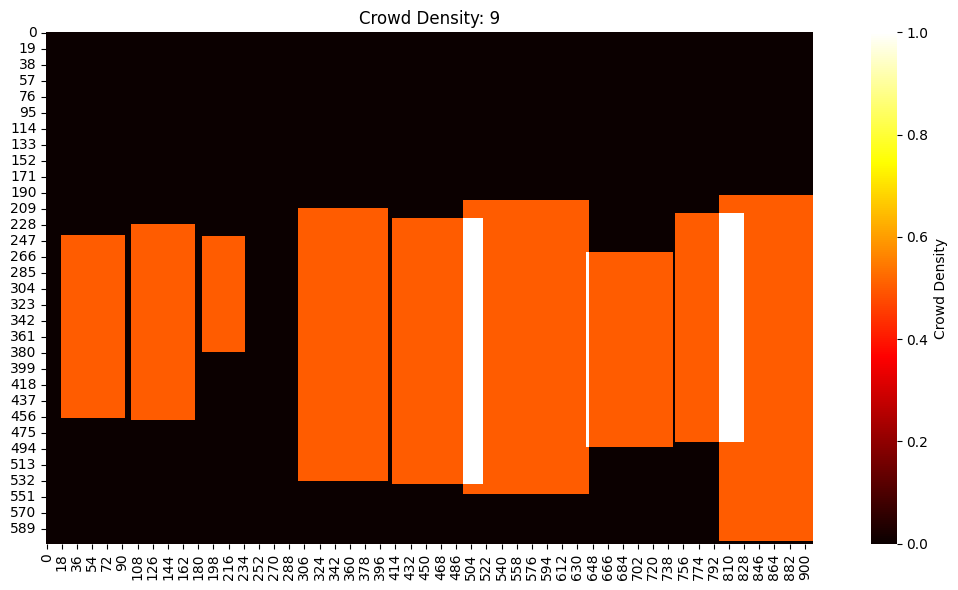

In [ ]:
# Normalize the heatmap
heatmap = heatmap / heatmap.max()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 6))

sns.heatmap(heatmap, cmap="hot", cbar_kws={'label': 'Crowd Density'})
plt.title('Crowd Density Heatmap')

plt.imshow(image)
plt.title(f"Crowd Density: {crowd_density}")

plt.tight_layout()
plt.show()